In [71]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [72]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [73]:
ims = search_images_ddg('grizzly bear')

In [75]:
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)

Path('images/grizzly.jpg')

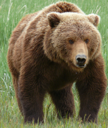

In [76]:
im = Image.open(dest)
im.to_thumb(128,128)

In [77]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
    for o in bear_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_ddg(f'{o} bear')
        download_images(dest, urls=results)

Our folder has image files, as we'd expect:

In [78]:
fns = get_image_files(path)
fns

(#566) [Path('bears/grizzly/46efd738-249b-4575-8819-556ead392f7d.jpg'),Path('bears/grizzly/77dd7428-43c0-40c7-8ff7-83e48869e012.jpg'),Path('bears/grizzly/27439ca1-1cd3-41a2-8190-72646d179256.jpg'),Path('bears/grizzly/45ee88b1-c29e-4d20-952c-21646f2e6fbb.jpg'),Path('bears/grizzly/f725399d-e6fd-49f8-8e31-4c6b7db28083.jpg'),Path('bears/grizzly/e728ed1b-9c05-4144-a398-69957eea666b.jpg'),Path('bears/grizzly/deb57a46-5883-486b-9f26-16a59fad444a.jpg'),Path('bears/grizzly/71e6e318-6c11-47af-aceb-768802341b09.jpg'),Path('bears/grizzly/50767d12-d3c1-4f97-b6e4-8831e623f581.jpg'),Path('bears/grizzly/52567c01-89fb-42d9-b507-382f6b53661b.jpg')...]

In [79]:
failed = verify_images(fns)
failed

(#28) [Path('bears/grizzly/1d86e411-c4cb-4996-8502-72ddb6eaaf0d.jpg'),Path('bears/grizzly/4968a977-2b02-4296-832c-f383da7c8751.jpg'),Path('bears/teddy/badb6515-3a15-470e-b2f5-24ed3d7df155.png'),Path('bears/teddy/566e39ac-78a6-46d1-8a4f-a58874706230.JPG'),Path('bears/teddy/cc55d6fc-a259-425d-b95a-f58397dcd167.jpg'),Path('bears/teddy/37ee4bf8-611b-44f9-9bc3-fec229e3c1d9.jpg'),Path('bears/teddy/e6c769aa-c321-45bf-91d9-a36ad4ce1777.JPG'),Path('bears/teddy/56f5222c-e6bc-4e0c-a872-a2cd06a9562f.jpg'),Path('bears/teddy/c0da9173-2ba2-4a1d-a573-8b49e2168233.jpg'),Path('bears/teddy/09d8110d-b953-4564-9735-bbc8e3c1342b.jpg')...]

In [80]:
failed.map(Path.unlink);

In [81]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [82]:
dls = bears.dataloaders(path)

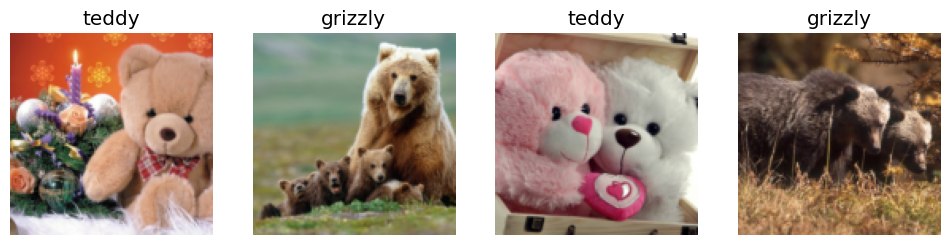

In [83]:
dls.valid.show_batch(max_n=4, nrows=1)

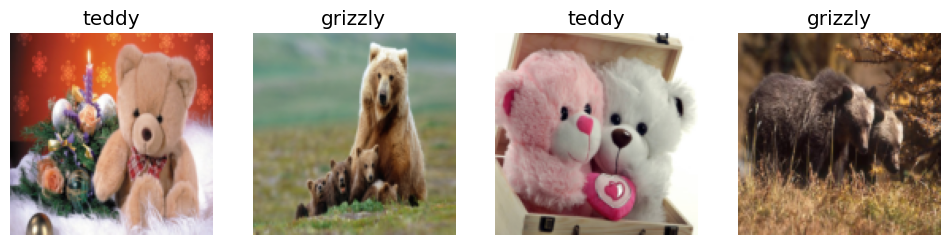

In [84]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

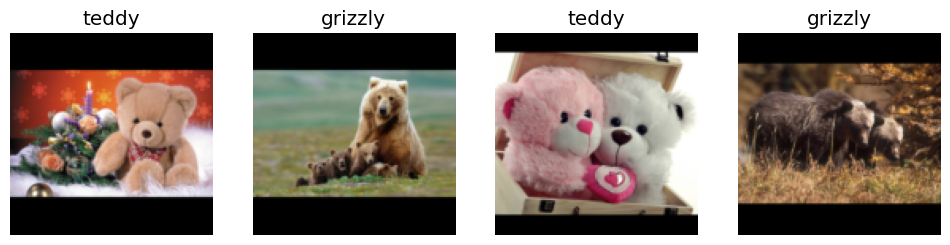

In [85]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

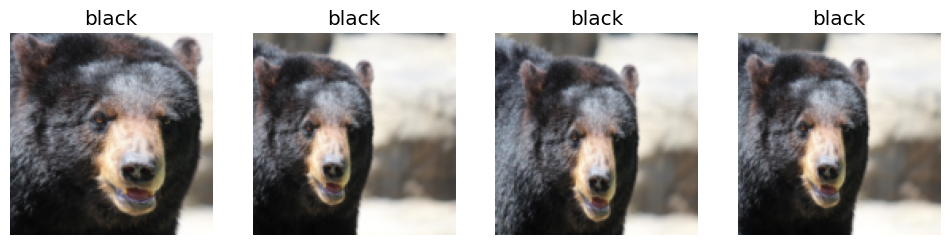

In [86]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

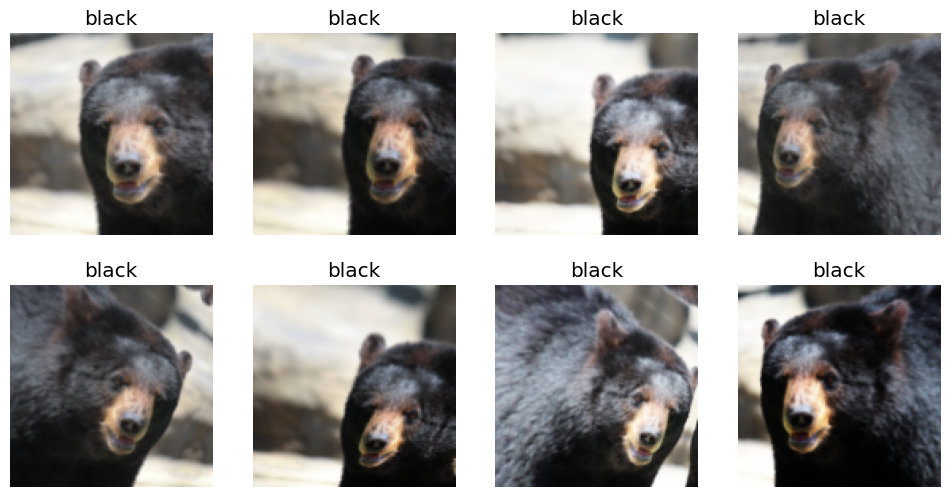

In [87]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [88]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [89]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 57.0MB/s]


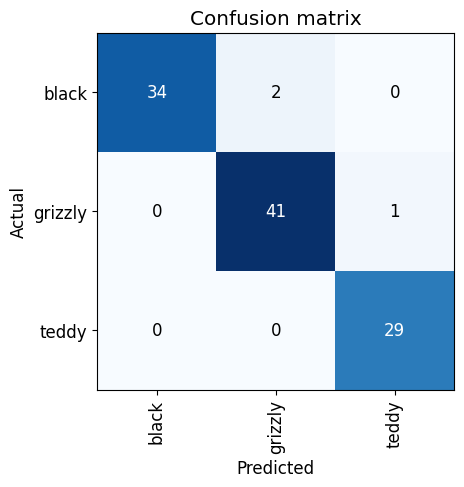

In [90]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

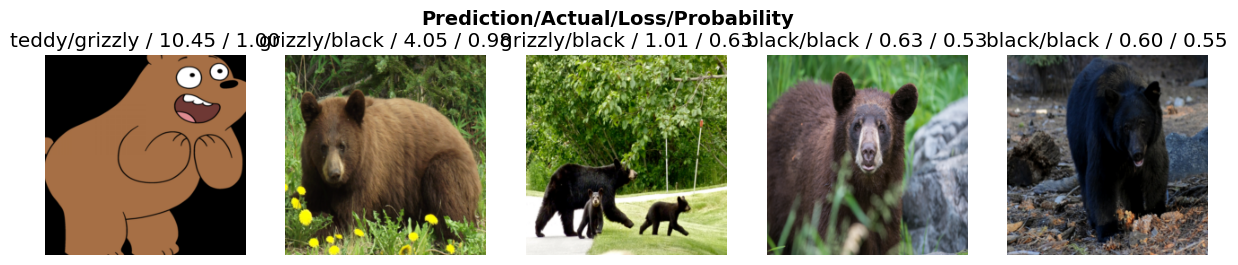

In [91]:
interp.plot_top_losses(5, nrows=1)

In [92]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [93]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

> note: No Need for Big Data: After cleaning the dataset using these steps, we generally are seeing 100% accuracy on this task. We even see that result when we download a lot fewer images than the 150 per class we're using here. As you can see, the common complaint that _you need massive amounts of data to do deep learning_ can be a very long way from the truth!

In [94]:
learn.export()

In [95]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [96]:
learn_inf = load_learner(path/'export.pkl')

In [97]:
learn_inf.predict('images/grizzly.jpg')

('grizzly', tensor(1), tensor([8.8756e-04, 9.9910e-01, 8.9455e-06]))

In [98]:
learn_inf.dls.vocab

['black', 'grizzly', 'teddy']

We can see here that if we index into the vocab with the integer returned by `predict` then we get back "grizzly," as expected. Also, note that if we index into the list of probabilities, we see a nearly 1.00 probability that this is a grizzly.

### Creating a Notebook App from the Model

In [99]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

<img alt="An upload button" width="159" src="https://github.com/fastai/fastbook/blob/master/images/att_00008.png?raw=1">

Now we can grab the image:

In [100]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [101]:
img = PILImage.create(btn_upload.data[-1])

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

We can use an `Output` widget to display it:

In [102]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

<img alt="Output widget representing the image" width="117" src="https://github.com/fastai/fastbook/blob/master/images/att_00009.png?raw=1">

Then we can get our predictions:

In [103]:
pred,pred_idx,probs = learn_inf.predict(img)

and use a `Label` to display them:

In [104]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 0.9991')

`Prediction: grizzly; Probability: 1.0000`

We'll need a button to do the classification. It looks exactly like the upload button:

In [105]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [106]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

You can test the button now by pressing it, and you should see the image and predictions update automatically!

We can now put them all in a vertical box (`VBox`) to complete our GUI:

In [107]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [108]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

IndexError: ignored